In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from xmovie import Movie
import seawater as sw
import cmocean as cm
import proplot as pplt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
ds = xr.open_dataset("data/output_coarsened.nc")
ds = ds.assign_coords(time=ds.time.astype("float")*1e-9/86400)

In [3]:
# ds = xr.open_dataset("data/output.nc")
# ds = ds.assign_coords(time=ds.time.astype("float")*1e-9/86400)

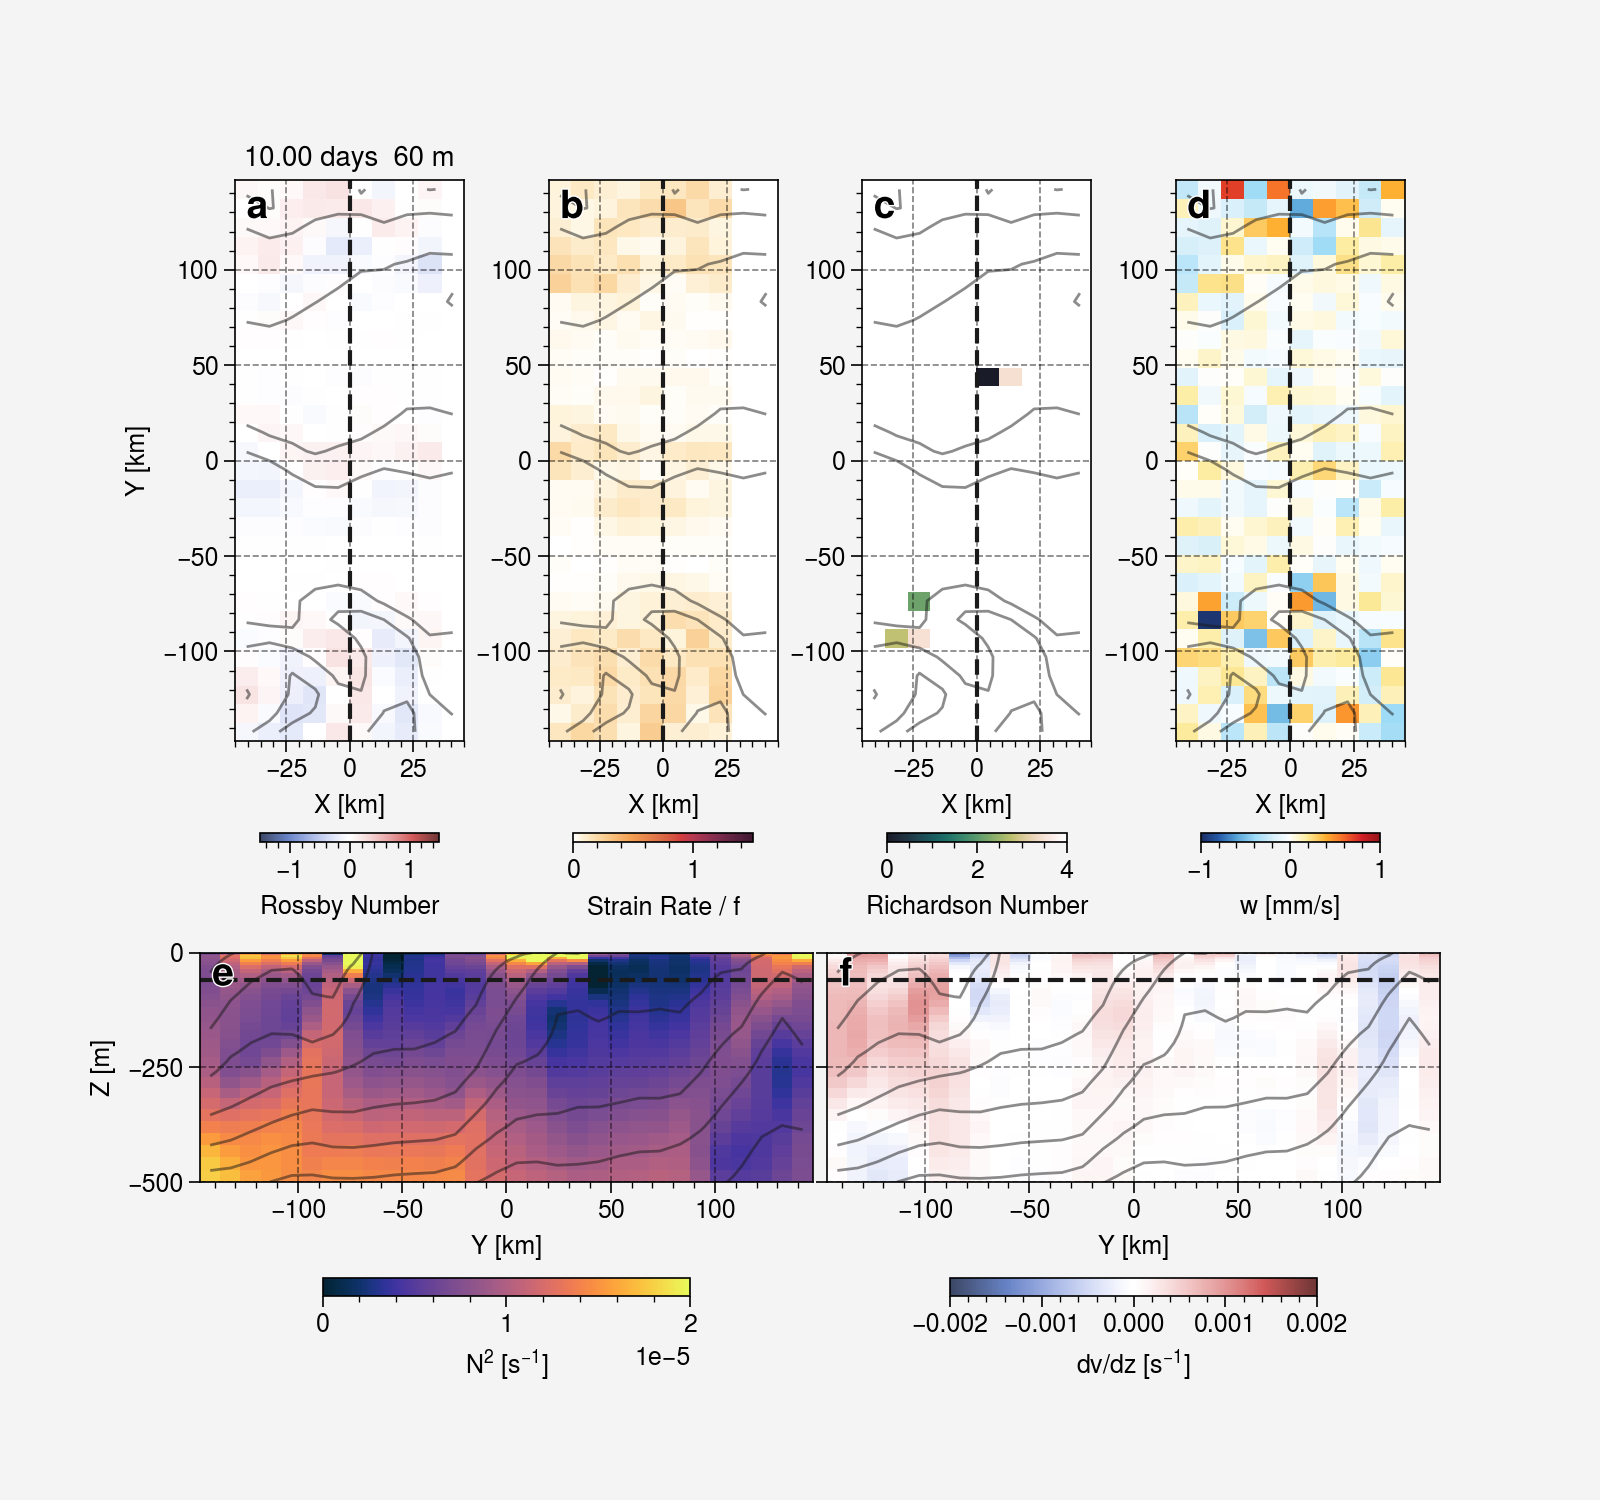

In [7]:
fig = plt.figure()
tt = 30

fig.set_size_inches((8,7.5))

zi = -60
f = sw.f(60)

dsi = ds.isel(time=tt).interp(xF=ds.xC,yF=ds.yC,zF=ds.zC)
dsi = dsi.assign(N2=dsi.b.differentiate("zC"))

gradb = np.abs((dsi.b.differentiate("xC")+dsi.b.differentiate("yC")))
zeta = (dsi.v.differentiate("xC")-dsi.u.differentiate("yC"))

dsi = dsi.assign(
    w = dsi.w*1e3,
    Ro = zeta/f,
    dvdz = dsi.v.differentiate("zC"),
    pv = ((f+zeta)*dsi.N2 - (gradb**2)/f)*1e9,
    Ri = dsi.N2/(dsi.v.differentiate("zC")**2+dsi.u.differentiate("zC")**2),
    S = np.sqrt((dsi.u.differentiate("xC")-dsi.v.differentiate("yC"))**2 + (dsi.v.differentiate("xC")+dsi.u.differentiate("yC"))**2)/f,
)

dsi = dsi.assign_coords(xC=dsi.xC*1e-3,yC=dsi.yC*1e-3).sel(yC=slice(-150,150))

kw = dict(
    Ro = dict(vmin=-1.5,vmax=1.5,cmap=pplt.Colormap("Div"),add_colorbar=False),
    dvdz = dict(vmin=-0.002,vmax=0.002,cmap=pplt.Colormap("Div"),add_colorbar=False),
    S = dict(vmin=0,vmax=1.5,cmap=pplt.Colormap("Fire"),add_colorbar=False),
    Ri = dict(vmin=0,vmax=4,cmap=pplt.Colormap("Boreal_r"),add_colorbar=False),
    w = dict(vmin=-1,vmax=1,cmap=pplt.Colormap("ColdHot"),add_colorbar=False),
    pv = dict(vmin=0,vmax=3,cmap=pplt.Colormap("Glacial"),add_colorbar=False),
    rho = dict(levels=np.arange(1020,1028,0.1),colors="0.1",linewidths=1,alpha=0.5),
    N2 = dict(vmin=0,vmax=2.e-5,cmap=pplt.Colormap("thermal"),add_colorbar=False)
)

label = dict(
    Ro = "Rossby Number",
    dvdz = "dv/dz [s$^{-1}$]",
    S = "Strain Rate / f",
    pv = "Erthel's PV 10$^{-9}$ [s$^{-3}$]",
    Ri = "Richardson Number",
    w = "w [mm/s]",
    N2 = "N$^2$ [s$^{-1}$]"   
)

ax = fig.subplot_mosaic([
    ["Ro","Ro","S","S","Ri","Ri","w","w"],
    ["Ro","Ro","S","S","Ri","Ri","w","w"],
    ["N2_s","N2_s","N2_s","N2_s","dvdz_s","dvdz_s","dvdz_s","dvdz_s"]
])

fig.subplots_adjust(wspace=0.1,hspace=0.01)

letters = ["a","b","c","d"]
for i,p in enumerate(["Ro","S","Ri","w"]):
    C = dsi.sel(zC=zi,method="nearest")[p].plot(ax=ax[p],**kw[p])
    (-(1026/9.82)*dsi.sel(zC=zi,method="nearest").b).plot.contour(ax=ax[p],**kw["rho"])
    fig.colorbar(C,ax=ax[p],label=label[p],orientation="horizontal",pad=0.12,shrink=0.6)
    
    txt = ax[p].text(0.05,0.95,letters[i],fontsize=14,va="center",fontweight="bold",transform=ax[p].transAxes)
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])
    
    ax[p].set(
        aspect=0.75,
        xlabel="",
        ylabel="",
        title=""
    )

ax["Ro"].set(
    xlabel="X [km]",
    ylabel="Y [km]",
    title = f"{ds.isel(time=tt).time.values:.2f} days  {-zi:.0f} m"
)

ax["S"].set(
    xlabel="X [km]",
)

ax["Ri"].set(
    xlabel="X [km]",
)

ax["w"].set(
    xlabel="X [km]",
)

letters = ["e","f"]
for i,p in enumerate(["N2","dvdz"]):
    C = dsi.sel(xC=0,method="nearest")[p].plot(ax=ax[f"{p}_s"],**kw[p])
    fig.colorbar(C,ax=ax[f"{p}_s"],label=label[p],orientation="horizontal",pad=0.25,shrink=0.6)
    (-(1026/9.82)*dsi.sel(xC=0,method="nearest").b).plot.contour(ax=ax[f"{p}_s"],**kw["rho"])
    
    txt = ax[f"{p}_s"].text(0.02,0.90,letters[i],fontsize=14,va="center",fontweight="bold",transform=ax[f"{p}_s"].transAxes)
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])
    
    ax[f"{p}_s"].set(
        xticks = np.arange(-100,100+50,50),
        yticks = -np.arange(0,1000,250),
        ylim = [-500,0],
        title="",
        xlabel="Y [km]",
        ylabel="Z [m]"
    )
ax[f"{p}_s"].set(yticklabels=[],ylabel="")

_ = [ax[k].axvline(0,lw=1.5,ls="--",color="0.1") for k in ax.keys() if "_s" not in k]
_ = [ax[k].axhline(zi,lw=1.5,ls="--",color="0.1") for k in ax.keys() if "_s" in k]
_ = [ax[k].grid(True,ls="--",alpha=0.5) for k in ax]

In [8]:
def custom_plotfunc(ds, fig, tt, *args, **kwargs):
    
    fig.set_size_inches((8,7.5))

    zi = -60
    f = sw.f(60)

    dsi = ds.isel(time=tt).interp(xF=ds.xC,yF=ds.yC,zF=ds.zC)
    dsi = dsi.assign(N2=dsi.b.differentiate("zC"))

    gradb = np.abs((dsi.b.differentiate("xC")+dsi.b.differentiate("yC")))
    zeta = (dsi.v.differentiate("xC")-dsi.u.differentiate("yC"))

    dsi = dsi.assign(
        w = dsi.w*1e3,
        Ro = zeta/f,
        dvdz = dsi.v.differentiate("zC"),
        pv = ((f+zeta)*dsi.N2 - (gradb**2)/f)*1e9,
        Ri = dsi.N2/(dsi.v.differentiate("zC")**2+dsi.u.differentiate("zC")**2),
        S = np.sqrt((dsi.u.differentiate("xC")-dsi.v.differentiate("yC"))**2 + (dsi.v.differentiate("xC")+dsi.u.differentiate("yC"))**2)/f,
    )

    dsi = dsi.assign_coords(xC=dsi.xC*1e-3,yC=dsi.yC*1e-3).sel(yC=slice(-150,150))

    kw = dict(
        Ro = dict(vmin=-1.5,vmax=1.5,cmap=pplt.Colormap("Div"),add_colorbar=False),
        dvdz = dict(vmin=-0.002,vmax=0.002,cmap=pplt.Colormap("Div"),add_colorbar=False),
        S = dict(vmin=0,vmax=1.5,cmap=pplt.Colormap("Fire"),add_colorbar=False),
        Ri = dict(vmin=0,vmax=4,cmap=pplt.Colormap("Boreal_r"),add_colorbar=False),
        w = dict(vmin=-1,vmax=1,cmap=pplt.Colormap("ColdHot"),add_colorbar=False),
        pv = dict(vmin=0,vmax=3,cmap=pplt.Colormap("Glacial"),add_colorbar=False),
        rho = dict(levels=np.arange(1020,1028,0.1),colors="0.1",linewidths=1,alpha=0.5),
        N2 = dict(vmin=0,vmax=2.e-5,cmap=pplt.Colormap("thermal"),add_colorbar=False)
    )

    label = dict(
        Ro = "Rossby Number",
        dvdz = "dv/dz [s$^{-1}$]",
        S = "Strain Rate / f",
        pv = "Erthel's PV 10$^{-9}$ [s$^{-3}$]",
        Ri = "Richardson Number",
        w = "w [mm/s]",
        N2 = "N$^2$ [s$^{-1}$]"   
    )

    ax = fig.subplot_mosaic([
        ["Ro","Ro","S","S","Ri","Ri","w","w"],
        ["Ro","Ro","S","S","Ri","Ri","w","w"],
        ["N2_s","N2_s","N2_s","N2_s","dvdz_s","dvdz_s","dvdz_s","dvdz_s"]
    ])

    fig.subplots_adjust(wspace=0.1,hspace=0.01)

    letters = ["a","b","c","d"]
    for i,p in enumerate(["Ro","S","Ri","w"]):
        C = dsi.sel(zC=zi,method="nearest")[p].plot(ax=ax[p],**kw[p])
        (-(1026/9.82)*dsi.sel(zC=zi,method="nearest").b).plot.contour(ax=ax[p],**kw["rho"])
        fig.colorbar(C,ax=ax[p],label=label[p],orientation="horizontal",pad=0.12,shrink=0.6)

        txt = ax[p].text(0.05,0.95,letters[i],fontsize=14,va="center",fontweight="bold",transform=ax[p].transAxes)
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])

        ax[p].set(
            aspect=0.75,
            xlabel="",
            ylabel="",
            title=""
        )

    ax["Ro"].set(
        xlabel="X [km]",
        ylabel="Y [km]",
        title = f"{ds.isel(time=tt).time.values:.2f} days  {-zi:.0f} m"
    )

    ax["S"].set(
        xlabel="X [km]",
    )

    ax["Ri"].set(
        xlabel="X [km]",
    )

    ax["w"].set(
        xlabel="X [km]",
    )

    letters = ["e","f"]
    for i,p in enumerate(["N2","dvdz"]):
        C = dsi.sel(xC=0,method="nearest")[p].plot(ax=ax[f"{p}_s"],**kw[p])
        fig.colorbar(C,ax=ax[f"{p}_s"],label=label[p],orientation="horizontal",pad=0.25,shrink=0.6)
        (-(1026/9.82)*dsi.sel(xC=0,method="nearest").b).plot.contour(ax=ax[f"{p}_s"],**kw["rho"])

        txt = ax[f"{p}_s"].text(0.02,0.90,letters[i],fontsize=14,va="center",fontweight="bold",transform=ax[f"{p}_s"].transAxes)
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])

        ax[f"{p}_s"].set(
            xticks = np.arange(-100,100+50,50),
            yticks = -np.arange(0,1000,250),
            ylim = [-500,0],
            title="",
            xlabel="Y [km]",
            ylabel="Z [m]"
        )
    ax[f"{p}_s"].set(yticklabels=[],ylabel="")

    _ = [ax[k].axvline(0,lw=1.5,ls="--",color="0.1") for k in ax.keys() if "_s" not in k]
    _ = [ax[k].axhline(zi,lw=1.5,ls="--",color="0.1") for k in ax.keys() if "_s" in k]
    _ = [ax[k].grid(True,ls="--",alpha=0.5) for k in ax]
    
    return None, None


In [9]:
mov_custom = Movie(ds, custom_plotfunc, input_check=False)

In [10]:
mov_custom.save('img/movie_dvdz_coarsened_from10days.mp4', overwrite_existing=True, framerate=5)

Movie created at movie_dvdz_coarsened_from10days.mp4


In [ ]:
ds